<a href="https://colab.research.google.com/github/abusel9/Spam_Emails_Analysis/blob/main/Spam_Email_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Email Analysis
### By Anna Busel and two other contributors who's names are excluded for privacy


This was a final project for a statistical analysis class. We worked on all aspects of this project together. By choice, I took a lead role in data visualization, creating compelling visual representations of the data. The visualizations I developed were instrumental in guiding the subsequent numerical analysis by providing valuable insights and highlighting patterns and trends. By effectively communicating complex information via visual means, I enabled the team to concentrate on key areas of analysis, resulting in more targeted and well-informed decisions and analysis. For example, visualization is a fast and easy way to check for collinearity, which is important to account for in multi-variable models. Visualization also gave an idea of which variables to exclude in the final model. I also wrote most of the interpretations of the results.


## Imports

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


import seaborn as sns
import statsmodels.api as sm
from io import StringIO
from tabulate import tabulate

## Data

In [ ]:
col_names = pd.read_csv('spam-names.txt', skiprows = 32, header = None, sep=':')[0].to_list()
col_names.append('class')
train = pd.read_csv('https://www.math.ucsd.edu/~wez243/spam-train.txt', header = None, names = col_names )
test = pd.read_csv('https://mathweb.ucsd.edu/~wez243/spam-test.txt', header = None, names = col_names)
test.head()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.12               0.12           0.24           0.0   
1            0.00               0.00           0.32           0.0   
2            0.00               0.00           0.00           0.0   
3            0.00               0.00           0.40           0.0   
4            0.51               0.43           0.29           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           1.34            0.12              0.00                0.12   
1           0.64            0.64              0.64                0.32   
2           0.00            0.00              0.00                0.00   
3           0.40            0.20              0.00                0.00   
4           0.14            0.03              0.00                0.18   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...        0.061        0.020   
1             0.32            0.00  ...        0.000        0.156   
2             0.00            0.00  ...        0.000        0.000   
3             0.00            1.01  ...        0.000        0.030   
4             0.54            0.62  ...        0.012        0.078   

   char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0          0.0        0.041        0.041        0.000   
1          0.0        0.000        0.156        0.000   
2          0.0        0.000        0.000        0.000   
3          0.0        0.000        0.302        0.000   
4          0.0        0.443        0.510        0.133   

   capital_run_length_average  capital_run_length_longest  \
0                       2.351                          69   
1                       1.752                          19   
2                       1.666                           6   
3                       1.727                          11   
4                       6.590                         739   

   capital_run_length_total  class  
0                       254      1  
1                       149      1  
2                        30      0  
3                       190      1  
4                      2333      1  

[5 rows x 58 columns]

In [ ]:
X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

## Helpers

In [ ]:
def print_results(name ,train_preds, test_preds):
    print('\n\n')
    print('=========================================================================================================')
    print('{} results:'.format(name))
    print('=========================================================================================================\n')
    print('The {} error rate for the training set is {}'.format(
        name,
        cal_classification_error_rate(train_preds, y_train)
    ))
    print('The {} error rate for the test set is {}'.format(
        name,
        cal_classification_error_rate(test_preds, y_test)
    ))
    print('\n')

def cal_classification_error_rate(preds, trues):
    return (len(trues) - sum(np.round(preds) == trues)) / len(trues)

def vis(temp):
    fig = plt.figure(figsize=(20, 580))
    j = 1
    for i in range(len(col_names) - 1):
        col = col_names[i]
        df = temp.iloc[:,[i,-1]]
        plt.subplot(58, 2, j)
        plt.scatter(df[col_names[i]],df['class'],c=df['class'])
        plt.title('{} vs. class'.format(col))
        plt.ylabel('class')
        j+=1
        plt.subplot(58, 2, j)
        j+=1
        plt.hist(df[df['class'] == 0][col], bins = 10, alpha = 0.5, color = 'blue')
        plt.hist(df[df['class'] == 1][col], bins = 10, alpha = 0.5, color = 'orange')
        plt.legend([0,1])
        plt.title('histgram of {}'.format(col))

def discretize(x): return 1 if x > 0 else 0
def discretize_df(df):
    for i in df.columns:
        df[i] = df[i].apply(lambda x: discretize(x))
    return df


In [ ]:
results = {}
for i in ['Standardized', 'Log_Transformed', 'Discretized']:
    results[i] = {}
    for j in ['Logistic_Regression', 'LDA', 'QDA', 'Linear_SVM', 'Nonlinear_SVM', 'Random_Forest']:
        results[i][j] = {}
        for k in ['train', 'test']:
            results[i][j][k] = None

In [ ]:
from sklearn.preprocessing import scale
from pandas import DataFrame

## 1. Standardize the columns so that they all have zero mean and unit variance;

In [ ]:
X_train_std  = DataFrame(scale(X_train), index = X_train.index, columns = X_train.columns)
X_test_std = DataFrame(scale(X_test), index = X_test.index, columns = X_test.columns)

In [ ]:
X_train_std.head()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0       -0.349707          -0.167384      -0.570454     -0.045809   
1       -0.349707          -0.167384       0.603722      0.023519   
2       -0.160249          -0.167384       0.225598     -0.045809   
3       -0.349707          -0.167384      -0.570454     -0.045809   
4       -0.349707          -0.167384      -0.570454     -0.045809   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0      -0.483547       -0.340743         -0.281928           -0.278916   
1      -0.483547       -0.340743         -0.281928           -0.278916   
2      -0.282066        0.074204         -0.281928            0.069170   
3      -0.483547       -0.340743         -0.281928           -0.278916   
4      -0.483547        1.063692         -0.281928           -0.278916   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0        -0.320442       -0.386249  ...             -0.107424    -0.155810   
1         0.075861       -0.030636  ...             -0.107424     0.874420   
2        -0.320442       -0.386249  ...             -0.107424    -0.028733   
3        -0.320442       -0.386249  ...             -0.107424    -0.155810   
4        -0.320442       -0.386249  ...             -0.107424    -0.155810   

   char_freq_(  char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0     2.116718    -0.149246    -0.078312    -0.333582    -0.134707   
1     0.833498     0.894701    -0.247461    -0.006562    -0.134707   
2    -0.222485    -0.149246    -0.311899    -0.333582    -0.134707   
3    -0.601213    -0.149246    -0.311899    -0.333582    -0.134707   
4     0.067131    -0.149246    -0.311899    -0.333582    -0.134707   

   capital_run_length_average  capital_run_length_longest  \
0                   -0.084888                   -0.273157   
1                   -0.084737                   -0.093134   
2                   -0.090936                   -0.218367   
3                   -0.116367                   -0.359255   
4                   -0.112950                   -0.304465   

   capital_run_length_total  
0                 -0.423201  
1                  0.680904  
2                  0.811760  
3                 -0.498852  
4                 -0.402754  

[5 rows x 57 columns]

In [ ]:
X_train_std.mean().head()

word_freq_make       6.950206e-17
word_freq_address    5.502246e-18
word_freq_all        9.846125e-18
word_freq_3d        -2.316735e-18
word_freq_our        1.007780e-16
dtype: float64

### 1. (a) For each version of the data, visualize it using the tools introduced in the class.

In [ ]:
temp = X_train_std.join(y_train)
vis(temp)

**Interpretation:** In these graphs we can see that certain words seem to be more predictive of a spam email than others. For example, looking at the scatterplot for "word_freq_credit vs. class", it appears that non-spam emails(the purple dots at the bottom) have far fewer occurences of the word than spam emails (the yellow dots at the top); in this dataset, only spam emails had upwards of 6 occurences of the word "credit", suggesting that "credit" may be a good predictor for whether an email is spam. The same can be seen for "word_freq_000" and the inverse appears to be true for "word_freq_hp", "word_freq_hpl", "word_freq_george", "word_freq_lab", "word_freq_857", "word_freq_415", "word_freq_technology", "word_freq_pm", "word_freq_cs" and some others. In those cases, it would mean that a higher frequency of those specific words would be predictive of a non-spam emails. On the other hand, for variables such as "capital_run_length_total", "char_freq_!", "char_freq_(", "word_freq_report", "word_freq_people", and "word_freq_mail" (among others) there does not appear to be a clear separation on the x-axis between the yellow(spam email) and purple(non-spam email) dots, suggesting that the frequency of those words or characters cannot reliably predit whether an email is spam.

In [ ]:
X_train_std.boxplot(figsize=(100,20), column = col_names[:-1])

<Axes: >

**Interpretation:** This graph of the boxplots shows the distributions for the frequency of the selected words/characters. Though this does not give a lot of information about the predictive abilities of the variables, we can see that certain words/characters are more commonly present in the dataset than others. For the word "3d", we can see most of the dots lie close to 0, with very few being between 4 and 30. This means that the emails that contain the word "3d" usually have fewer than 5 occurences of the word, and most commonly less than 2. Some emails do seem to contain far more occurences of the word than typical; if all of those emails are classified as "spam", then the word "3d" would be highly predictive of a spam email. However, for the word frequency of "email", we can see a fairly compact distribution, with most of the emails in the dataset containing fewer than 5 occurences of the word, and none containing more than 10. This might make it harder to use "email" as a predicting word, since the range for number of occurences is so small, meaning that both spam and non-spam emails contain about the same number of occurences of "email". In fact, referencing the scatterplots above, we can see that this is true; there is no clear separation between frequency of the word in spam and non-spam emails. This makes sense, since "email" is a common word to use in an email. It is important to note that one cannot solely use the boxplot to make predictions; one example is "word_freq_85". Similarly to the word "email", "85" also has a compact distribution, with most emails containing fewer than 5 occurences, and and only one having more than 10. However, when we reference the scatterplots above, we can see that there is some type of separation between the occurences of "85" in spam and non-spam emails. In fact, none of the spam emails contain more than 5 occurences of "85", meaning that more occurences of "85" may be predictive of a non-spam email; however, when there are less than 5 occurences, distinction is more difficult.

In [ ]:
corr_abs = temp.corr().abs().sort_values(by='class', ascending=False)
top_20_corr = corr_abs.iloc[:20,:]
for col in top_20_corr.index:
    corr_val = temp[['class', col]].corr().iloc[0,1]
    print(f"{col:<20} {corr_val:.3f}")


class                1.000
word_freq_your       0.388
word_freq_000        0.340
char_freq_$          0.337
word_freq_remove     0.327
word_freq_our        0.308
capital_run_length_longest 0.299
word_freq_you        0.292
capital_run_length_total 0.288
word_freq_hp         -0.264
word_freq_hpl        -0.238
word_freq_receive    0.238
word_freq_business   0.235
char_freq_!          0.229
word_freq_money      0.229
word_freq_free       0.222
word_freq_addresses  0.210
word_freq_order      0.210
word_freq_credit     0.210
word_freq_email      0.207


**Interpretation:** Here we have the top 20 correlations between each variable and "class". This particular matrix was computed using absolute value, so we are seeing the top 20 variables most highly correlated with class, whether positive or negative. We can see that higher frequency of the word "remove" can be fairly predictive of a spam email, while a higher frequency of the word "hp" can be predictive of a non-spam email. Overall, there are more positive associations, indicating that spam emails can be identified more clearly by a higher usage of certain words or phrases, rather than a lower usage of words or phrases.

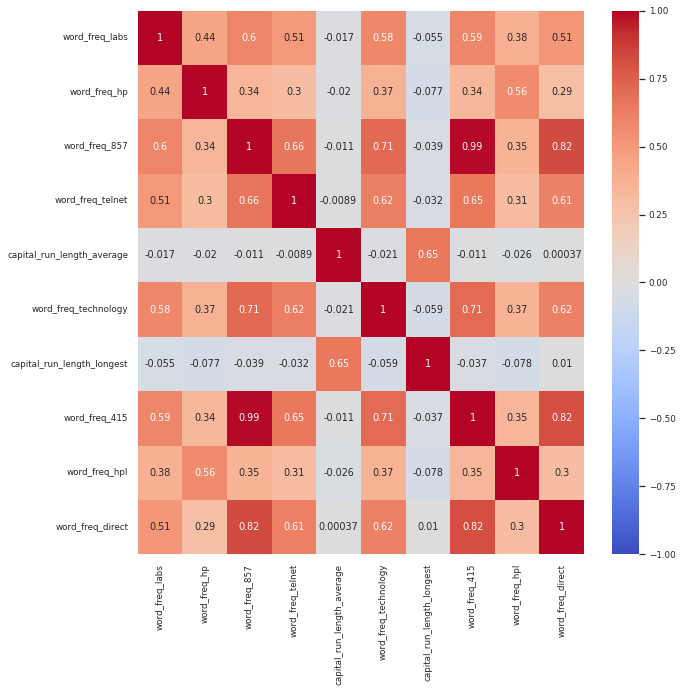

In [ ]:
#finding the top correlations between any variables(versus class like above) and creating a heatmap
corr_matrix = temp.corr()
corr_matrix = corr_matrix.mask(np.triu(np.ones_like(corr_matrix, dtype=bool)))
corr_series = corr_matrix.stack()
sorted_correlations = corr_series.abs().sort_values(ascending=False)
top_correlations = sorted_correlations[:15]
cols = [col for col in top_correlations.index.get_level_values(0).tolist()
        if col != 'class'] + [col for col in top_correlations.index.get_level_values(1).tolist()
                               if col != 'class']
cols = list(set(cols))
corr_subset = temp[cols]
sns.set(font_scale=.8)
sns.set_style('whitegrid')
plt.figure(figsize=(10, 10))
sns.heatmap(corr_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()



**Interpretation:** This is a visual display of the correlation between the variables themselves. A heatmap is a useful way to check for multi-collinearity. For example, we can see that "word_freq_857" and "word_freq_415" are almost perfectly positively correlated with a correlation of 0.99. Any high correlations, whether positive or negative(though we do not have any strong negative correlations) , can affect the accuracy of a predictor. This means that if we were to use the standardized data to predict spam or non-spam, we should exclude some of the highly correlated variables. This also lets us know that we do not need to worry about strong negative inter-variable correlation in the future, so there is no need to plot using only the absolute value matrix.

In [ ]:
#finding the top correlations between any variables(versus class like above) and creating scatterplots to make sure we have linear data
temp = X_train_std.join(y_train)
corr_matrix = temp.corr()
corr_matrix = corr_matrix.mask(np.triu(np.ones_like(corr_matrix, dtype=bool)))
corr_series = corr_matrix.stack()
sorted_correlations = corr_series.sort_values(ascending=False)
top_correlations = sorted_correlations[:15]
cols = top_correlations.index.get_level_values(0).tolist() + top_correlations.index.get_level_values(1).tolist()
cols = list(set(cols))
corr_subset = temp[cols]
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
sns.pairplot(corr_subset, diag_kind='scatter', height=2.5)
plt.show()


**Interpretation:** As mentioned before, for correlation to be a valid measure, we need to make sure data is linear. As inferred above, "word_freq_857" and "word_freq_415" are almost perfectly linearly correlated, meaning there is multi-collinearity. The same appears to be true for "word_freq_857" and "word_freq_direct", and "word_freq_technology", so "word_freq_857" might have to be excluded from a final predictor altogether. Any scatterplot which has an obvious line may indicate collinearity between the variables. Any scatterplots that have a significant number of points not falling along are likely not contributing to multicollinearity; an example would be "word_freq_hpl" and "word_freq_labs", where most of the points are scattered randomly between 0 and 5 both on the x and y axes.

### 1. (b) For each version of the data, fit a logistic regression model. Interpret the results, and report the classification errors on both the training and test sets. Do any of the 57 features/predictors appear to be statistically significant? If so, which ones?

In [ ]:
def part_b(X_train_std, y_train, X_test_std, y_test):
    logit_std = sm.Logit(y_train,X_train_std)
    result_std = logit_std.fit()
    print('=========================================================================================================')
    print('Regression Summary:')
    print(result_std.summary())

    y_pred_train_std = result_std.predict(X_train_std)
    y_pred_test_std = result_std.predict(X_test_std)

    print_results('Logistic Regression',y_pred_train_std, y_pred_test_std)
    print('=========================================================================================================')
    print('Vairables with the Highest Level of Significance:')
    print('=========================================================================================================\n')
    results_std_df = pd.read_csv(StringIO(result_std.summary().tables[1].as_csv()),
                                 names=['coef', 'stdErr', 'z', 'p', 0.025, 0.975])
    results_std_df = results_std_df.sort_values(by='p', ascending = True)
    print(results_std_df.iloc[:10, :4])
    return y_pred_train_std, y_pred_test_std

In [ ]:
log_std_train_preds, log_std_test_preds = part_b(X_train_std, y_train, X_test_std, y_test)

Optimization terminated successfully.
         Current function value: 0.209362
         Iterations 12
Regression Summary:
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 3067
Model:                          Logit   Df Residuals:                     3010
Method:                           MLE   Df Model:                           56
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                  0.6884
Time:                        21:14:51   Log-Likelihood:                -642.11
converged:                       True   LL-Null:                       -2060.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
word_freq_make                -0.0428      0.080     -0

Directly above, we have listed the top 10 most significant variables. Since the p-value is 0 for each of them, each of them is statistically significant at the commonly used alpha levels of 0.05, and 0.01.

In [ ]:
results['Standardized']['Logistic_Regression']['train'] = cal_classification_error_rate(
    log_std_train_preds, y_train
)
results['Standardized']['Logistic_Regression']['test'] = cal_classification_error_rate(
    log_std_test_preds, y_test
)

In [ ]:
headers = ['Dataset', 'Model', 'Train Error', 'Test Error']
rows = []
rows.append(['Standardized', 'Logistic Regression', results['Standardized']['Logistic_Regression']['train'], results['Standardized']['Logistic_Regression']['test']])
print(tabulate(rows, headers=headers))


Dataset       Model                  Train Error    Test Error
------------  -------------------  -------------  ------------
Standardized  Logistic Regression      0.0772742     0.0795306


**Interpretation:** Since the errors on both the training and test data are similar and low, it seems like the model is not overfitting to the training data and is fairly accurate at predicting new data.

### 1. (c) Apply both linear and quadratic discriminant analysis methods to the standardized data, and the log-transformed data. What are the classification errors (training and test)?

In [ ]:
def part_c(X_train_std, X_test_std, y_train, y_test):
    LDA_std = LinearDiscriminantAnalysis()
    LDA_std.fit(X_train_std, y_train)
    LDA_std_train_preds = LDA_std.predict(X_train_std)
    LDA_std_test_preds = LDA_std.predict(X_test_std)

    QDA_std = QuadraticDiscriminantAnalysis()
    QDA_std.fit(X_train_std, y_train)
    QDA_std_train_preds = QDA_std.predict(X_train_std)
    QDA_std_test_preds = QDA_std.predict(X_test_std)

    print_results('LDA',LDA_std_train_preds, LDA_std_test_preds)
    print_results('QDA',QDA_std_train_preds, QDA_std_test_preds)
    return LDA_std_train_preds, LDA_std_test_preds, QDA_std_train_preds, QDA_std_test_preds

In [ ]:
LDA_std_train_preds, LDA_std_test_preds, QDA_std_train_preds, QDA_std_test_preds = part_c(X_train_std, X_test_std, y_train, y_test)





LDA results:

The LDA error rate for the training set is 0.10172807303553962
The LDA error rate for the test set is 0.10299869621903521





QDA results:

The QDA error rate for the training set is 0.17867623084447343
The QDA error rate for the test set is 0.17470664928292046




In [ ]:
results['Standardized']['LDA']['train'] = cal_classification_error_rate(
    LDA_std_train_preds, y_train
)
results['Standardized']['LDA']['test'] = cal_classification_error_rate(
    LDA_std_test_preds, y_test
)
results['Standardized']['QDA']['train'] = cal_classification_error_rate(
    QDA_std_train_preds, y_train
)
results['Standardized']['QDA']['test'] = cal_classification_error_rate(
    QDA_std_test_preds, y_test
)
rows.append(['Standardized', 'LDA', results['Standardized']['LDA']['train'], results['Standardized']['LDA']['test']])
rows.append(['Standardized', 'QDA', results['Standardized']['QDA']['train'], results['Standardized']['QDA']['test']])
print(tabulate(rows, headers=headers))

Dataset       Model                  Train Error    Test Error
------------  -------------------  -------------  ------------
Standardized  Logistic Regression      0.0772742     0.0795306
Standardized  LDA                      0.101728      0.102999
Standardized  QDA                      0.178676      0.174707


**Interpretation:** Here we can see that the logistic regression yields the smallest train and test error; while the QDA yields the highest. Though the train and test errors are quite close together, the test errors are still slightly higher for each model, which means there could be overfitting. This makes sense, as above we found instances of multicollinearity.

### 1. (d) Apply linear and nonlinear support vector machine classifiers to each version of the data. What are the classification errors (training and test)?

In [ ]:
def part_d(X_train_std, X_test_std, y_train, y_test):

    #parameters = {'C': [1,2]}
    linear_SVC = SVC(kernel = 'linear')
    #linear_clf = GridSearchCV(linear_SVC, parameters)
    linear_SVC.fit(X_train_std, y_train)
    #pd.DataFrame(linear_SVC.cv_results_).head()
    #linear_clf.best_params_
    SVM_linear_std_train_preds = linear_SVC.predict(X_train_std)
    SVM_linear_std_test_preds = linear_SVC.predict(X_test_std)

    parameters = {'C': np.logspace(-5,2,10),
                 'gamma': np.logspace(-5,2,10)}
    rbf_SVC = SVC(kernel = 'rbf')
    rbf_clf = GridSearchCV(rbf_SVC, parameters)
    rbf_clf.fit(X_train_std,y_train)
    #print('parameters results:')
    #pd.DataFrame(rbf_clf.cv_results_).head()
    print('Best Parameters for Nonlinear SVM from Cross Validation:')
    print(rbf_clf.best_params_)

    SVM_rbf_std_train_preds = rbf_clf.predict(X_train_std)
    SVM_rbf_std_test_preds = rbf_clf.predict(X_test_std)

    print_results('Linear SVM',SVM_linear_std_train_preds, SVM_linear_std_test_preds)
    print_results('Nonlinear SVM',SVM_rbf_std_train_preds, SVM_rbf_std_test_preds)
    return SVM_linear_std_train_preds, SVM_linear_std_test_preds, SVM_rbf_std_train_preds, SVM_rbf_std_test_preds

In [ ]:
# costly to run:
SVM_linear_std_train_preds, SVM_linear_std_test_preds, SVM_rbf_std_train_preds, SVM_rbf_std_test_preds = part_d(X_train_std, X_test_std, y_train, y_test)



Best Parameters for Nonlinear SVM from Cross Validation:
{'C': 100.0, 'gamma': 0.01291549665014884}



Linear SVM results:

The Linear SVM error rate for the training set is 0.06488425171177047
The Linear SVM error rate for the test set is 0.07170795306388526





Nonlinear SVM results:

The Nonlinear SVM error rate for the training set is 0.013694163677861103
The Nonlinear SVM error rate for the test set is 0.046284224250325946




In [ ]:
results['Standardized']['Linear_SVM']['train'] = cal_classification_error_rate(
    SVM_linear_std_train_preds, y_train
)
results['Standardized']['Linear_SVM']['test'] = cal_classification_error_rate(
    SVM_linear_std_test_preds, y_test
)
results['Standardized']['Nonlinear_SVM']['train'] = cal_classification_error_rate(
    SVM_rbf_std_train_preds, y_train
)
results['Standardized']['Nonlinear_SVM']['test'] = cal_classification_error_rate(
    SVM_rbf_std_test_preds, y_test
)
rows.append(['Standardized', 'Linear_SVM', results['Standardized']['Linear_SVM']['train'], results['Standardized']['Linear_SVM']['test']])
rows.append(['Standardized', 'Nonlinear_SVM', results['Standardized']['Nonlinear_SVM']['train'], results['Standardized']['Nonlinear_SVM']['test']])
print(tabulate(rows, headers=headers))

Dataset       Model                  Train Error    Test Error
------------  -------------------  -------------  ------------
Standardized  Logistic Regression      0.0772742     0.0795306
Standardized  QDA                      0.178676      0.174707
Standardized  LDA                      0.101728      0.102999
Standardized  Linear_SVM               0.0648843     0.071708
Standardized  Nonlinear_SVM            0.0136942     0.0462842


**Interpretation**: Here we can see that both Linear_SVM and Nonlinear_SVM yielded lower errors than the previous models. However, for both, the test error is relatively higher than the train error when compared to the previous models, meaning overfitting was more of a problem.

### 1. (e) Apply tree-based classifiers to this data. What are the classification errors (training and test)?

In [ ]:
def part_e(X_train_std, X_test_std, y_train, y_test):
    randomForest = RandomForestClassifier(n_estimators=200, max_depth = 10, random_state=69)
    randomForest.fit(X_train_std, y_train)
    randomForest_std_train_preds = randomForest.predict(X_train_std)
    randomForest_std_test_preds = randomForest.predict(X_test_std)
    print_results('Random Forest',randomForest_std_train_preds, randomForest_std_test_preds)
    return randomForest_std_train_preds, randomForest_std_test_preds

In [ ]:
randomForest_std_train_preds, randomForest_std_test_preds = part_e(X_train_std, X_test_std, y_train, y_test)




Random Forest results:

The Random Forest error rate for the training set is 0.024127812194326703
The Random Forest error rate for the test set is 0.04302477183833116




In [ ]:
results['Standardized']['Random_Forest']['train'] = cal_classification_error_rate(
    randomForest_std_train_preds, y_train
)
results['Standardized']['Random_Forest']['test'] = cal_classification_error_rate(
    randomForest_std_test_preds, y_test
)
rows.append(['Standardized', 'Random_Forest', results['Standardized']['Random_Forest']['train'], results['Standardized']['Random_Forest']['test']])
print(tabulate(rows, headers=headers))

Dataset       Model                  Train Error    Test Error
------------  -------------------  -------------  ------------
Standardized  Logistic Regression      0.0772742     0.0795306
Standardized  QDA                      0.178676      0.174707
Standardized  LDA                      0.101728      0.102999
Standardized  Linear_SVM               0.0648843     0.071708
Standardized  Nonlinear_SVM            0.0136942     0.0462842
Standardized  Random_Forest            0.0241278     0.0430248


**Interpretation**: We can see that the Random Forest model had a higher train error than the previously most accurate model (Nonlinear SVM), but a slightly lower test error, which makes it the best fitting model.

## 2. Transform the features using log(x_ij+1)

In [ ]:
X_train_log = X_train.apply(lambda x: np.log(x + 1))
X_test_log = X_test.apply(lambda x: np.log(x+1))

In [ ]:
X_train_log.head()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0        0.000000                0.0       0.000000       0.00000   
1        0.000000                0.0       0.463734       0.10436   
2        0.058269                0.0       0.336472       0.00000   
3        0.000000                0.0       0.000000       0.00000   
4        0.000000                0.0       0.000000       0.00000   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0       0.000000        0.000000               0.0            0.000000   
1       0.000000        0.000000               0.0            0.000000   
2       0.122218        0.122218               0.0            0.122218   
3       0.000000        0.000000               0.0            0.000000   
4       0.000000        0.364643               0.0            0.000000   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0          0.00000        0.000000  ...                   0.0     0.000000   
1          0.10436        0.207014  ...                   0.0     0.204572   
2          0.00000        0.000000  ...                   0.0     0.027615   
3          0.00000        0.000000  ...                   0.0     0.000000   
4          0.00000        0.000000  ...                   0.0     0.000000   

   char_freq_(  char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0     0.476234     0.000000     0.184818     0.000000          0.0   
1     0.279146     0.107059     0.054488     0.072321          0.0   
2     0.081580     0.000000     0.000000     0.000000          0.0   
3     0.000000     0.000000     0.000000     0.000000          0.0   
4     0.139762     0.000000     0.000000     0.000000          0.0   

   capital_run_length_average  capital_run_length_longest  \
0                    1.264409                    2.772589   
1                    1.265820                    3.663562   
2                    1.206270                    3.135494   
3                    0.916291                    1.609438   
4                    0.960499                    2.484907   

   capital_run_length_total  
0                  4.127134  
1                  6.400257  
2                  6.501290  
3                  3.218876  
4                  4.276666  

[5 rows x 57 columns]

### 2. (a) For each version of the data, visualize it using the tools introduced in the class.

In [ ]:
temp = X_train_log.join(y_train)
temp.corr().sort_values(by = 'class', ascending = False).iloc[:20,:]

word_freq_make  word_freq_address  word_freq_all  \
class                             0.175054           0.052663       0.256511   
capital_run_length_longest        0.166790           0.080636       0.248244   
char_freq_!                       0.181970           0.037273       0.236551   
word_freq_your                    0.201192           0.066753       0.239827   
capital_run_length_total          0.160628           0.009677       0.245115   
char_freq_$                       0.186227           0.053802       0.165821   
capital_run_length_average        0.130422           0.097361       0.190434   
word_freq_remove                  0.027843           0.047521       0.078094   
word_freq_free                    0.147037           0.015000       0.136099   
word_freq_000                     0.212509          -0.004092       0.168337   
word_freq_our                     0.098805           0.022581       0.158450   
word_freq_you                     0.185298           0.008235       0.221961   
word_freq_money                   0.258188           0.014963       0.118251   
word_freq_business                0.145465          -0.007806       0.073468   
word_freq_receive                 0.113362           0.064502       0.097651   
word_freq_over                    0.120043          -0.002707       0.150902   
word_freq_all                     0.127292           0.035678       1.000000   
word_freq_credit                  0.060956           0.007110       0.105842   
word_freq_internet                0.027906           0.014688       0.049159   
word_freq_email                   0.020944           0.125751       0.202302   

                            word_freq_3d  word_freq_our  word_freq_over  \
class                           0.072536       0.382471        0.262550   
capital_run_length_longest      0.073967       0.233262        0.204581   
char_freq_!                     0.009969       0.170015        0.141141   
word_freq_your                  0.009736       0.254057        0.142219   
capital_run_length_total        0.066669       0.216434        0.214614   
char_freq_$                     0.006855       0.112485        0.162297   
capital_run_length_average      0.063411       0.185748        0.099645   
word_freq_remove                0.008960       0.281439        0.105041   
word_freq_free                  0.005751       0.204566        0.059148   
word_freq_000                   0.011231       0.153102        0.256404   
word_freq_our                   0.009361       1.000000        0.145338   
word_freq_you                   0.008489       0.218115        0.155455   
word_freq_money                 0.051469       0.051945        0.171901   
word_freq_business             -0.020233       0.220306        0.104531   
word_freq_receive              -0.018171       0.136288        0.105924   
word_freq_over                 -0.007581       0.145338        1.000000   
word_freq_all                  -0.009589       0.158450        0.150902   
word_freq_credit               -0.000506       0.120925        0.124387   
word_freq_internet              0.008092       0.089023        0.172689   
word_freq_email                 0.014766       0.150424        0.111519   

                            word_freq_remove  word_freq_internet  \
class                               0.415025            0.249928   
capital_run_length_longest          0.205365            0.184634   
char_freq_!                         0.183217            0.107479   
word_freq_your                      0.191251            0.168094   
capital_run_length_total            0.125390            0.183934   
char_freq_$                         0.103621            0.131903   
capital_run_length_average          0.229453            0.122806   
word_freq_remove                    1.000000            0.056760   
word_freq_free                      0.162570            0.070371   
word_freq_000                       0.113326            0.156029   
word_freq_our          

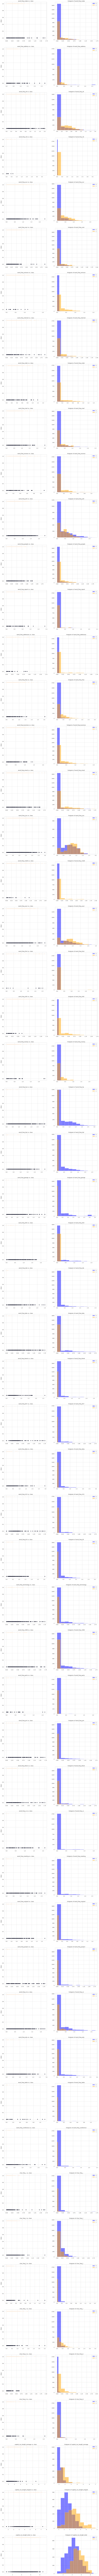

In [ ]:
vis(temp)

**Interpretation**: The scatterplot patterns are similar to those of part 1. The histograms are a little more clear in displaying the information of the scatterplots, as they are more distinct from one another.

<Axes: >

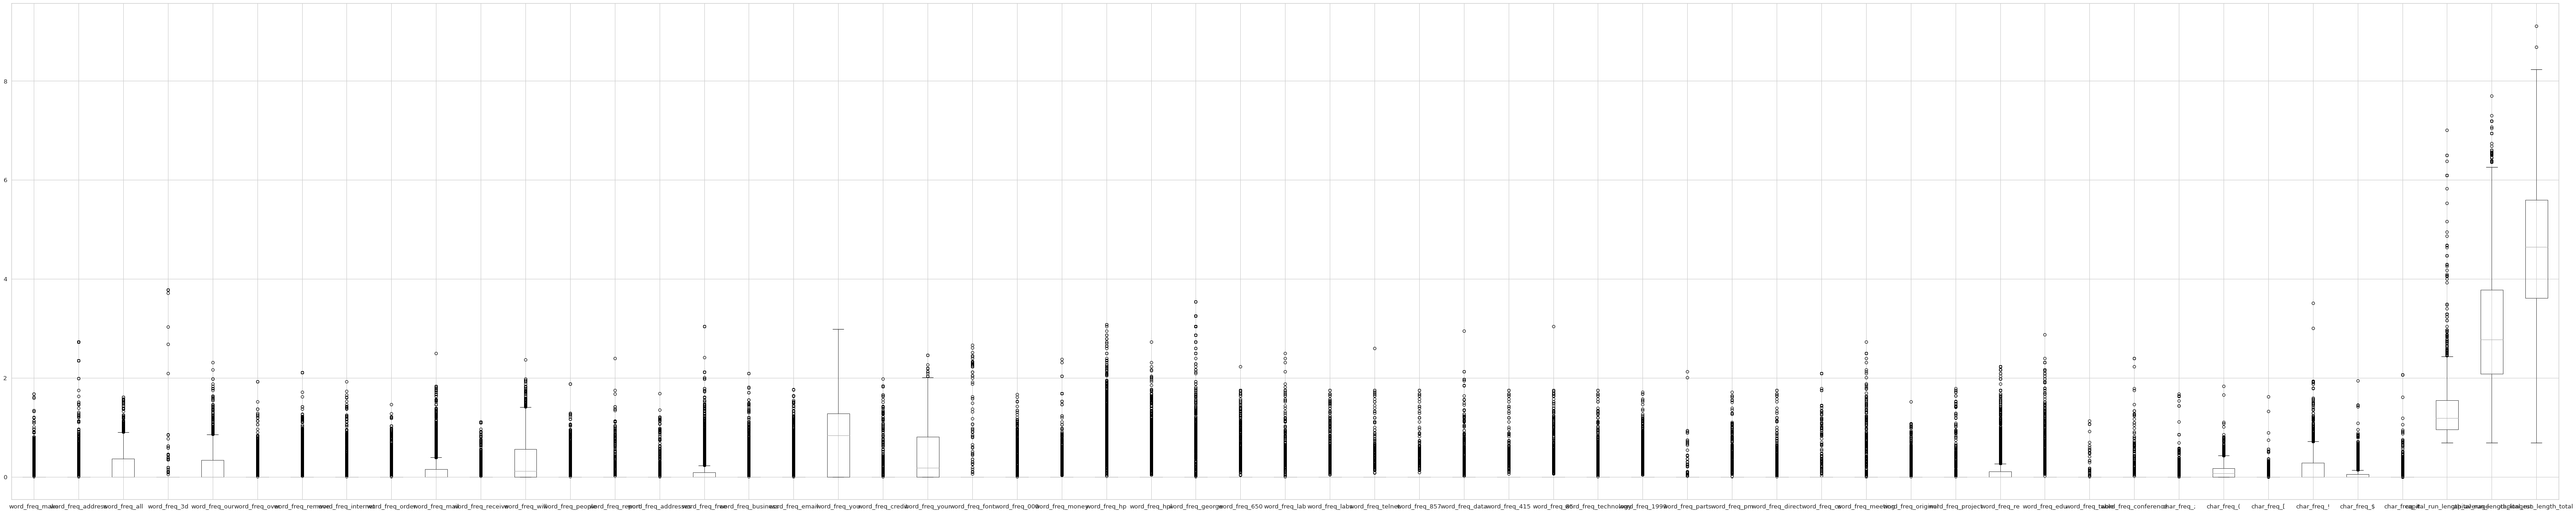

In [ ]:
X_train_log.boxplot(figsize=(100,20), column = col_names[:-1])

**Interpretation**: Most of the patterns in the boxplots are similar to part one as well. However, there are a couple of differences. For the capital_run_length_average, capital_run_length_longest, and capital_run_length_total variables, the points all lay outside of the box, specifically on the higher than third quartile side. This did not happen with the standardized data, which leads us to the conclusion that the data for those particular variables and others displaying the same pattern (such as "word_freq_all" for example) was very right skewed. This means that there were a few observations with very high values that were driving up the mean and the upper end of the distribution.

In [ ]:
temp = X_train_log.join(y_train)

In [ ]:
corr_abs = temp.corr().abs().sort_values(by='class', ascending=False)
top_20_corr = corr_abs.iloc[:20,:]
for col in top_20_corr.index:
    corr_val = temp[['class', col]].corr().iloc[0,1]
    print(f"{col:<20} {corr_val:.3f}")

class                1.000
capital_run_length_longest 0.504
char_freq_!          0.478
word_freq_your       0.475
capital_run_length_total 0.439
char_freq_$          0.427
capital_run_length_average 0.418
word_freq_remove     0.415
word_freq_free       0.387
word_freq_000        0.385
word_freq_our        0.382
word_freq_you        0.363
word_freq_hp         -0.361
word_freq_money      0.351
word_freq_hpl        -0.293
word_freq_business   0.277
word_freq_receive    0.273
word_freq_over       0.263
word_freq_george     -0.262
word_freq_all        0.257


**Interpretation**: Many of the highly correlated variables stayed the same in the log-transformed data(from the standardized data), but the order and correlation changed. For example, capital_run_length_longest had a correlation of 0.299 in the standardized data, but now has a correlation of 0.504 in the log-transformed data. As shown by the boxplots, this particular variables was very skewed, so it makes sense that log transforming it could make it a more accurate predictor.

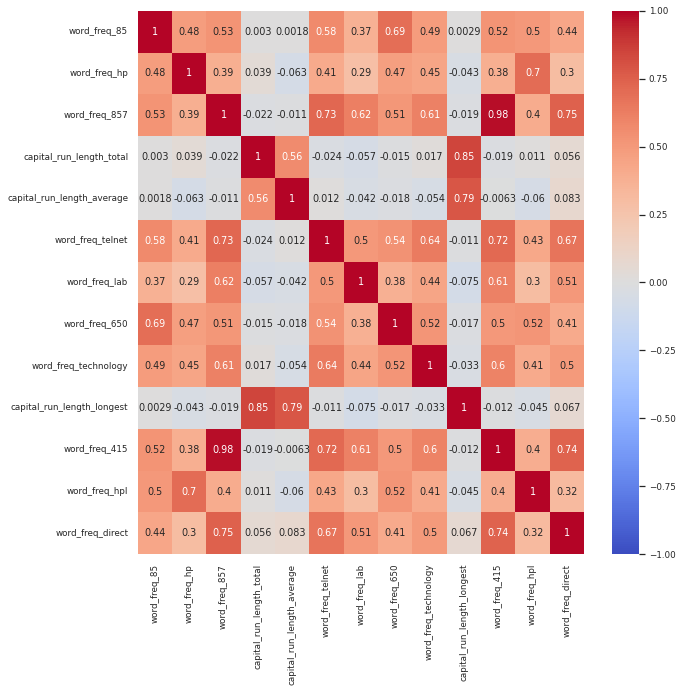

In [ ]:
#finding the top correlations between any variables(versus class like above) and creating a heatmap
corr_matrix = temp.corr()
corr_matrix = corr_matrix.mask(np.triu(np.ones_like(corr_matrix, dtype=bool)))
corr_series = corr_matrix.stack()
sorted_correlations = corr_series.abs().sort_values(ascending=False)
top_correlations = sorted_correlations[:15]
cols = [col for col in top_correlations.index.get_level_values(0).tolist()
        if col != 'class'] + [col for col in top_correlations.index.get_level_values(1).tolist()
                               if col != 'class']
cols = list(set(cols))
corr_subset = temp[cols]
sns.set(font_scale=.8)
sns.set_style('whitegrid')
plt.figure(figsize=(10, 10))
sns.heatmap(corr_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


**Interpretation**: We still see many of the same patterns here as we did in part 1. Log transform did not do much to lower multi-collinearity; for example, "word_freq_415" and "word_freq_857" are still very highly correlated.

In [ ]:
#finding the top correlations between any variables(versus class like above) and creating scatterplots to make sure we have linear data
temp = X_train_log.join(y_train)
corr_matrix = temp.corr()
corr_matrix = corr_matrix.mask(np.triu(np.ones_like(corr_matrix, dtype=bool)))
corr_series = corr_matrix.stack()
sorted_correlations = corr_series.sort_values(ascending=False)
top_correlations = sorted_correlations[:15]
cols = top_correlations.index.get_level_values(0).tolist() + top_correlations.index.get_level_values(1).tolist()
cols = list(set(cols))
corr_subset = temp[cols]
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
sns.pairplot(corr_subset, diag_kind='scatter', height=2.5)
plt.show()

**Interpretation**: Log transforming the data did not cause it to lose its linearity.

### 2. (b) For each version of the data, fit a logistic regression model. Interpret the results, and report the classification errors on both the training and test sets. Do any of the 57 features/predictors appear to be statistically significant? If so, which ones?

In [ ]:
log_log_train_preds, log_log_test_preds = part_b(X_train_log, y_train, X_test_log, y_test)
results['Log_Transformed']['Logistic_Regression']['train'] = cal_classification_error_rate(
    log_log_train_preds, y_train
)
results['Log_Transformed']['Logistic_Regression']['test'] = cal_classification_error_rate(
    log_log_test_preds, y_test
)

Optimization terminated successfully.
         Current function value: 0.184887
         Iterations 14
Regression Summary:
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 3067
Model:                          Logit   Df Residuals:                     3010
Method:                           MLE   Df Model:                           56
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                  0.7248
Time:                        21:21:32   Log-Likelihood:                -567.05
converged:                       True   LL-Null:                       -2060.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
word_freq_make                -0.3452      0.439     -0

**Interpretation**: Some of the most highly correlated variables remain the same as part 1, but three of them changed. We have "word_freq_free", "char_freq_!", and "char_freq_$" replaced by "word_freq_re", "capital_run_length_longest", and "word_freq_credit". All variables remain significant at alpha levels 0.01 and 0.05.

### 2. (c) Apply both linear and quadratic discriminant analysis methods to the standardized data, and the log-transformed data. What are the classification errors (training and test)?


In [ ]:
LDA_log_train_preds, LDA_log_test_preds, QDA_log_train_preds, QDA_log_test_preds = part_c(X_train_log, X_test_log, y_train, y_test)
results['Log_Transformed']['LDA']['train'] = cal_classification_error_rate(
    LDA_log_train_preds, y_train
)
results['Log_Transformed']['LDA']['test'] = cal_classification_error_rate(
    LDA_log_test_preds, y_test
)
results['Log_Transformed']['QDA']['train'] = cal_classification_error_rate(
    QDA_log_train_preds, y_train
)
results['Log_Transformed']['QDA']['test'] = cal_classification_error_rate(
    QDA_log_test_preds, y_test
)





LDA results:

The LDA error rate for the training set is 0.06031953048581676
The LDA error rate for the test set is 0.0651890482398957





QDA results:

The QDA error rate for the training set is 0.1587870883599609
The QDA error rate for the test set is 0.15710560625814862




### 2. (d) Apply linear and nonlinear support vector machine classifiers to each version of the data. What are the classification errors (training and test)?

In [ ]:
# costly to run:
SVM_linear_log_train_preds, SVM_linear_log_test_preds, SVM_rbf_log_train_preds, SVM_rbf_log_test_preds = part_d(X_train_log, X_test_log, y_train, y_test)
results['Log_Transformed']['Linear_SVM']['train'] = cal_classification_error_rate(
    SVM_linear_log_train_preds, y_train
)
results['Log_Transformed']['Linear_SVM']['test'] = cal_classification_error_rate(
    SVM_linear_log_test_preds, y_test
)
results['Log_Transformed']['Nonlinear_SVM']['train'] = cal_classification_error_rate(
    SVM_rbf_log_train_preds, y_train
)
results['Log_Transformed']['Nonlinear_SVM']['test'] = cal_classification_error_rate(
    SVM_rbf_log_test_preds, y_test
)


Best Parameters for Nonlinear SVM from Cross Validation:
{'C': 2.782559402207126, 'gamma': 0.4641588833612782}



Linear SVM results:

The Linear SVM error rate for the training set is 0.05836322138897946
The Linear SVM error rate for the test set is 0.0560625814863103





Nonlinear SVM results:

The Nonlinear SVM error rate for the training set is 0.007499184871209651
The Nonlinear SVM error rate for the test set is 0.031942633637548894




### 2. (e) Apply tree-based classifiers to this data. What are the classification errors (training and test)?

In [ ]:
randomForest_log_train_preds, randomForest_log_test_preds =  part_e(X_train_log, X_test_log, y_train, y_test)
results['Log_Transformed']['Random_Forest']['train'] = cal_classification_error_rate(
    randomForest_log_train_preds, y_train
)
results['Log_Transformed']['Random_Forest']['test'] = cal_classification_error_rate(
    randomForest_log_test_preds, y_test
)




Random Forest results:

The Random Forest error rate for the training set is 0.024127812194326703
The Random Forest error rate for the test set is 0.03585397653194263




**Interpretation**: All of the log-transformed models have lower test errors than their counteraprts in the standardized dataset. All of the log-transformed models aside from Random Forest have lower train errors than their counteraprts in the standardized dataset as well; the log-transformed Random Forest model has the same train error both in standardized and log-transformed.

## 3. Discretize each features using I(x_ij > 0)

In [ ]:
X_train_bi = discretize_df(X_train)
X_test_bi = discretize_df(X_test)
X_train_bi.head()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0               0                  0              0             0   
1               0                  0              1             1   
2               1                  0              1             0   
3               0                  0              0             0   
4               0                  0              0             0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0              0               0                 0                   0   
1              0               0                 0                   0   
2              1               1                 0                   1   
3              0               0                 0                   0   
4              0               1                 0                   0   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0                0               0  ...                     0            0   
1                1               1  ...                     0            1   
2                0               0  ...                     0            1   
3                0               0  ...                     0            0   
4                0               0  ...                     0            0   

   char_freq_(  char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0            1            0            1            0            0   
1            1            1            1            1            0   
2            1            0            0            0            0   
3            0            0            0            0            0   
4            1            0            0            0            0   

   capital_run_length_average  capital_run_length_longest  \
0                           1                           1   
1                           1                           1   
2                           1                           1   
3                           1                           1   
4                           1                           1   

   capital_run_length_total  
0                         1  
1                         1  
2                         1  
3                         1  
4                         1  

[5 rows x 57 columns]

### 3. (a) For each version of the data, visualize it using the tools introduced in the class.

In [ ]:
temp = X_train_bi.join(y_train)
temp.corr().sort_values(by = 'class', ascending = False).iloc[:20,:]

In [ ]:
vis(temp)

**Interpretation**: The scatterplots are not as useful here as they were in the previous two parts. However, the histograms do show us where there may be splits between spam and non-spam. For "char_freq_;", we see two bars; one at x = 0 with an orange bottom and blue top, and a smaller bar with the same split at x = 1. This indicates that there were a lot more emails in the dataset not containing that character than there were containing, and that most of those were non-spam.

<Axes: >

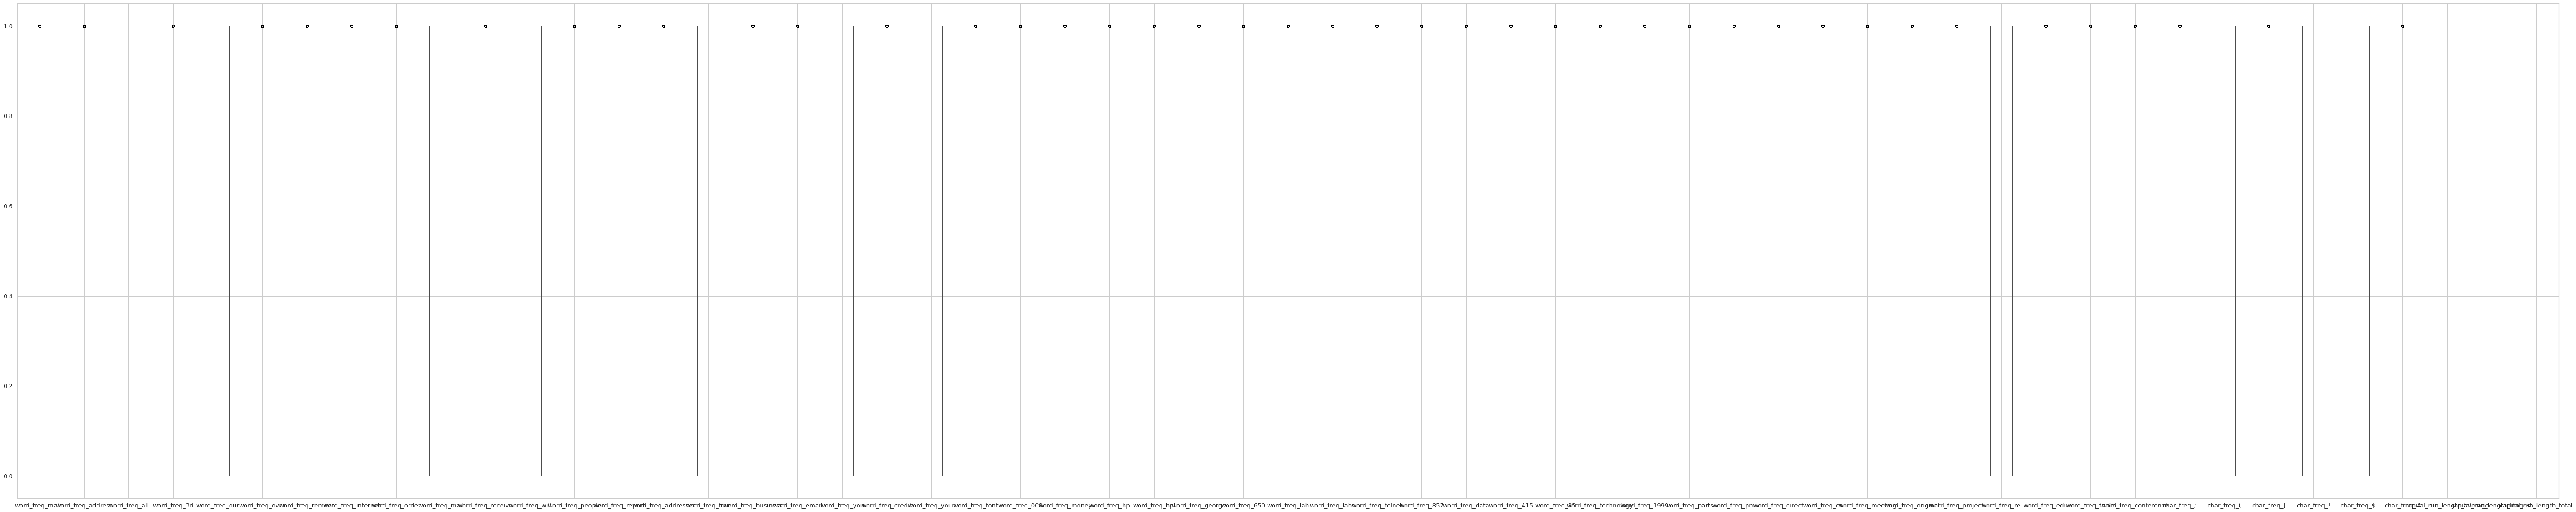

In [ ]:
X_train_bi.boxplot(figsize=(100,20), column = col_names[:-1])

In [ ]:
corr_abs = temp.corr().abs().sort_values(by='class', ascending=False)
top_20_corr = corr_abs.iloc[:20,:]
for col in top_20_corr.index:
    corr_val = temp[['class', col]].corr().iloc[0,1]
    print(f"{col:<20} {corr_val:.3f}")

class                1.000
word_freq_remove     0.547
char_freq_!          0.545
char_freq_$          0.538
word_freq_free       0.508
word_freq_money      0.490
word_freq_your       0.463
word_freq_our        0.436
word_freq_000        0.425
word_freq_hp         -0.403
word_freq_george     -0.347
word_freq_receive    0.346
word_freq_internet   0.341
word_freq_you        0.339
word_freq_mail       0.339
word_freq_hpl        -0.337
word_freq_credit     0.331
word_freq_all        0.325
word_freq_business   0.314
word_freq_over       0.297


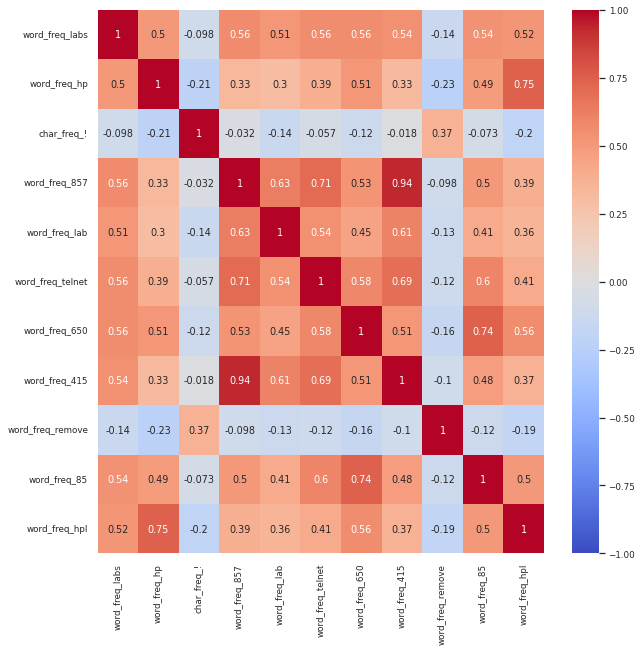

In [ ]:
#finding the top correlations between any variables(versus class like above) and creating a heatmap
corr_matrix = temp.corr()
corr_matrix = corr_matrix.mask(np.triu(np.ones_like(corr_matrix, dtype=bool)))
corr_series = corr_matrix.stack()
sorted_correlations = corr_series.abs().sort_values(ascending=False)
top_correlations = sorted_correlations[:15]
cols = [col for col in top_correlations.index.get_level_values(0).tolist()
        if col != 'class'] + [col for col in top_correlations.index.get_level_values(1).tolist()
                               if col != 'class']
cols = list(set(cols))
corr_subset = temp[cols]
sns.set(font_scale=.8)
sns.set_style('whitegrid')
plt.figure(figsize=(10, 10))
sns.heatmap(corr_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

**Interpretation**: We still are seeing some fairly high multi-collinearity here, although it is slightly reduced from the previous two parts.

### 3. (b) For each version of the data, fit a logistic regression model. Interpret the results, and report the classification errors on both the training and test sets. Do any of the 57 features/predictors appear to be statistically significant? If so, which ones?

In [ ]:
X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]
X_train_bi = discretize_df(X_train)
X_test_bi = discretize_df(X_test)

In [ ]:
log_bi_train_preds, log_bi_test_preds = part_b(X_train_bi, y_train, X_test_bi, y_test)
results['Discretized']['Logistic_Regression']['train'] = cal_classification_error_rate(
    log_bi_train_preds, y_train
)
results['Discretized']['Logistic_Regression']['test'] = cal_classification_error_rate(
    log_bi_test_preds, y_test
)

### 3. (d) Apply linear and nonlinear support vector machine classifiers to each version of the data. What are the classification errors (training and test)?

In [ ]:
SVM_linear_bi_train_preds, SVM_linear_bi_test_preds, SVM_rbf_bi_train_preds, SVM_rbf_bi_test_preds = part_d(X_train_bi, X_test_bi, y_train, y_test)
results['Discretized']['Linear_SVM']['train'] = cal_classification_error_rate(
    SVM_linear_bi_train_preds, y_train
)
results['Discretized']['Linear_SVM']['test'] = cal_classification_error_rate(
    SVM_linear_bi_test_preds, y_test
)
results['Discretized']['Nonlinear_SVM']['train'] = cal_classification_error_rate(
    SVM_rbf_bi_train_preds, y_train
)
results['Discretized']['Nonlinear_SVM']['test'] = cal_classification_error_rate(
    SVM_rbf_bi_test_preds, y_test
)



Best Parameters for Nonlinear SVM from Cross Validation:
{'C': 100.0, 'gamma': 0.4641588833612782}



Linear SVM results:

The Linear SVM error rate for the training set is 0.06031953048581676
The Linear SVM error rate for the test set is 0.07431551499348109





Nonlinear SVM results:

The Nonlinear SVM error rate for the training set is 0.006847081838930551
The Nonlinear SVM error rate for the test set is 0.041720990873533245




### 3. (e) Apply tree-based classifiers to this data. What are the classification errors (training and test)?

In [ ]:
randomForest_bi_train_preds, randomForest_bi_test_preds = part_e(X_train_bi, X_test_bi, y_train, y_test)
results['Discretized']['Random_Forest']['train'] = cal_classification_error_rate(
    randomForest_bi_train_preds, y_train
)
results['Discretized']['Random_Forest']['test'] = cal_classification_error_rate(
    randomForest_bi_test_preds, y_test
)

## Report classification errors using different methods and different preprocessed data in a table, and comment on the different performances.

Looking at the table above, the classification errors were highest when adopting standardized linear and quadratic discriminant analysis
and log transformed quadratic discriminant analysis. On the other hands, we can observe that the errors are lowest when applying
nonlinear support vector machine classifiers and tree-based classifiers. Comparing scaling and log transform, we can see that the overall
classification errors are lower at log transform. Therefore, the best model would be applying log transformed tree-based classifiers to the
data.


In [ ]:
d = results
df = pd.DataFrame.from_dict({(i,j,k): d[i][j][k]
                            for i in d.keys()
                            for j in d[i].keys()
                            for k in d[i][j].keys()},
                            orient='index')

df.index = pd.MultiIndex.from_tuples(df.index)
df

## Finally, use either a single method with properly chosen tuning parameter or a combination of several methods to design a classifier with test error rate as small as possible. Describe your recommended method and its performance.

To design a classifier with the smallest test error rates, we chose transforming the feature with log and applying tree-based classifiers.
More specifically, we first improved accuracy and reliability by transforming the features using log(xij +1). Given numbers of features in
our data, we applied random forest classifiers since it works great when dealing with high dimensional data and yielded lowest error
compared to other classifiers. Using this model, we got the error rate for training set is about 0.000326 and test set is about 0.02086.


In [ ]:
# Final Model:

#parameters = {'max_depth': range(1,100)}
#rf = RandomForestClassifier(
#    n_estimators = 500,
#    random_state = 1
#)
#final_clf = GridSearchCV(rf, parameters)
#final_clf.fit(X_train_log,y_train)
#print('Best Parameters for Nonlinear SVM from Cross Validation:')
#print(final_clf.best_params_)
final_clf = RandomForestClassifier(
    max_depth = 25,
    n_estimators = 500,
    random_state = 1
)
final_clf.fit(X_train_log,y_train)

In [ ]:
# Define list of columns to exclude
exclude_cols = ['word_freq_make', 'word_freq_all', 'word_freq_3d', 'word_freq_over', 'word_freq_internet', 'word_freq_order', 'word_freq_report', 'word_freq_font', 'word_freq_hpl', 'word_freq_650',                 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_415',                 'word_freq_technology', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs',                 'word_freq_table', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_#']

# Drop excluded columns from X_train_log and X_test_log
X_train_log = X_train_log.drop(exclude_cols, axis=1)
X_test_log = X_test_log.drop(exclude_cols, axis=1)

# Fit the model
final_clf = RandomForestClassifier(max_depth=25, n_estimators=500, random_state=1)
final_clf.fit(X_train_log, y_train)


In [ ]:
final_clf_train_preds = final_clf.predict(X_train_log)
final_clf_test_preds = final_clf.predict(X_test_log)
print_results('Final Model',final_clf_train_preds, final_clf_test_preds)


In [ ]:
# Just for fun:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes = (512, 16),
                   activation = 'relu',
                   max_iter = 1000).fit(X_train_bi, y_train)


In [ ]:
MLP_test_pred = clf.predict(X_test_bi)
MLP_train_pred = clf.predict(X_train_bi)
print_results('Final Model',MLP_train_pred, MLP_test_pred)